# Vision languamge models

In this notebook we will use two vision language models to inspect two images. At the end, if the model can determine which kind of structures are present in an image, e.g. blobs or membranes, we could guid code-generation techniques to write code specifically tailored for segmenting this image.

In [1]:
import openai
from skimage.io import imread
import stackview
from image_utilities import numpy_to_bytestream
import base64
from stackview._image_widget import _img_to_rgb

## Example images
First we load two example images.

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
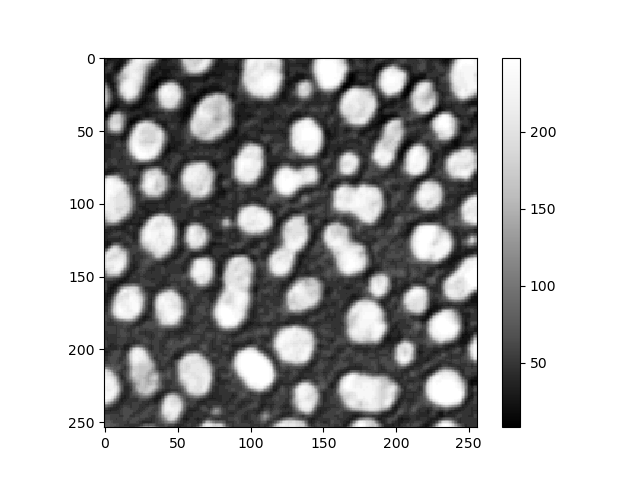
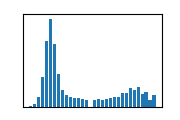

In [2]:
blobs = imread("../03b_image_processing/data/blobs.tif")
stackview.insight(blobs)

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 5, ..., 6, 3, 3],
                  ...,
                  [0, 0, 0, ..., 3, 2, 3],
                  [0, 0, 0, ..., 1, 4, 9],
                  [0, 0, 0, ..., 1, 4, 8]], dtype=uint8)
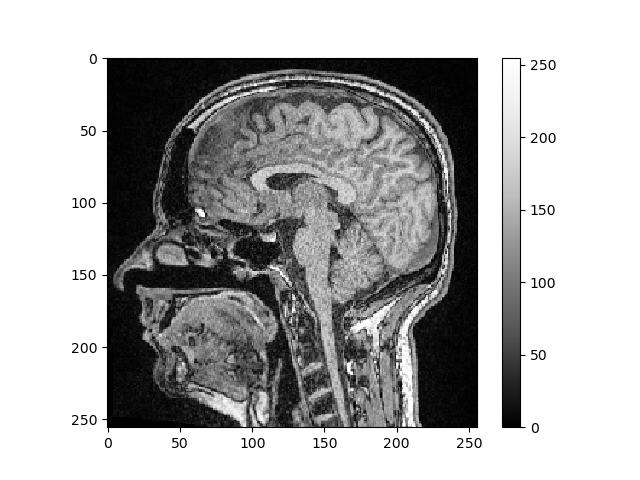
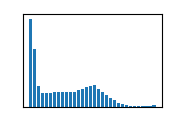

In [3]:
mri = imread("../03b_image_processing/data/Haase_MRT_tfl3d1.tif")[100]
stackview.insight(mri)

## LLAVA
The [LLAVA](https://llava-vl.github.io/) model is capable of describing images via the [ollama](https://ollama.com/) API.

In [4]:
def prompt_ollama(prompt:str, image, model="llava"):
    """A prompt helper function that sends a message to ollama
    and returns only the text response.
    """
    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    message = [{
        'role': 'user',
        'content': prompt,
        'images': [base64_image]
    }]
        
    # setup connection to the LLM
    client = openai.OpenAI(
        base_url = "http://localhost:11434/v1"
    )
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message
    )
    
    # extract answer
    return response.choices[0].message.content

In [5]:
prompt_ollama("what's in this image?", mri)

" I'm sorry, but it seems that the image you have provided is not visible. Please provide a link to the image or describe the contents of the image for me, and I can assist you further. "

In [6]:
prompt_ollama("How many bright blobs are in this image?", blobs)

' There are two bright blobs in the image. '

## ChatGPT 4-omni
We will now send the image to ChatGPT and ask it the same questions.

In [7]:
def prompt_chatGPT(prompt:str, image, model="gpt-4o"):
    """A prompt helper function that sends a message to openAI
    and returns only the text response.
    """
    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    message = [{"role": "user", "content": [
        {"type": "text", "text": prompt},
        {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }
    }]}]
            
    # setup connection to the LLM
    client = openai.OpenAI()
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message
    )
    
    # extract answer
    return response.choices[0].message.content

In [8]:
prompt_chatGPT("what's in this image?", mri)

"This image appears to show an MRI scan of a human head, focusing on the brain. The scan provides a detailed view of the brain's structures, including the cerebral cortex, cerebellum, brainstem, and other anatomical features. MRI scans are commonly used in medicine to diagnose and monitor conditions related to the brain and other parts of the body."

In [9]:
prompt_chatGPT("How many bright blobs are in this image?", blobs)

'There are 53 bright blobs in the image.'

## Exercise
Use a vision-language model to determine the content of an image, e.g. `membrane2d.tif`. Ask the model to differentiate these cases:
* An image with bright blob-like structures
* An image with membrane-like structures such as lines or meshes

Make sure the model response with the case only and no detailed explanation.